In [1]:
import requests as req
import pandas as pd
from geopy.distance import vincenty
from matplotlib import pyplot as plt
%matplotlib inline
import os

In [2]:
weather_dict = {'Date/Time': 'date', 'Max Temp': 'T_high', 
                'Min Temp': 'T_low', 'Total Rain (mm)': 'h_rain',
                'Total Snow (cm)': 'h_snow', 'Total Precip (mm)': 'h_all_precip'}

almanac_dict = {'Month': 'month', 'Day': 'day','Average Max. Temp.': 'T_high_avg',
                'Average Min. Temp.': 'T_low_avg', 'Highest Temp.': 'T_max', 'Lowest Temp.': 'T_min',
                'Highest Temp.Year': 'T_max_year', 'Lowest Temp. Year': 'T_min_year',
                'Highest Temp. Period': 'period_T_high', 'Lowest Temp. Period': 'period_T_low'}

def get_dist_km(stn_id_1, stn_id_2, df):
    
    i_1 = df.query('station_id == @stn_id_1').index[0]
    i_2 = df.query('station_id == @stn_id_2').index[0]

    coords_1 = (df.latitude_decimal_degrees[i_1], df.longitude_decimal_degrees[i_1])
    coords_2 = (df.latitude_decimal_degrees[i_2], df.longitude_decimal_degrees[i_2])
    
    dist = vincenty(coords_1, coords_2)
    
    return dist.kilometers

def download_daily_data_url(stn_id, year, month, interval):
    time_frame = {'hourly': '1', 'daily': '2', 'monthly': '3', 'almanac': '4'}
    url = ('http://climat.weather.gc.ca/climateData/bulkdata_e.html?format=csv&stationID=' + str(stn_id) 
           + '&Year=' + str(year) + '&Month=' + str(month) + '&Day=14&timeframe=' + time_frame[interval] 
           + '&submit= Download+Data')
    return url

def download_normals_url(stn_id, clm_id):
    url = ('http://climate.weather.gc.ca/climate_normals//bulkdata_e.html'
        + '?ffmt=csv&lang=e&prov=ON&yr=1981&stnID=' + str(stn_id) + '&climateID=' + str(clm_id) 
        + '+++++++++++++&submit=Download+Data')
    return url

def write_response(response, filename):
    f = open(filename, 'w')
    f.write(response.content)
    f.close()

def parse_daily_file(filepath, col_dict):
    "parse the files with daily data"
    f = open(filepath, 'r')
    s = f.readlines()
    f.close()
    obj = {}
    n = 0
    
    while s[n] != '\n':
        prop = s[n].split(',')[0][1:-1]
        val = s[n].split(',')[1][1:-2]
        obj[prop] = val
        n+=1
    
    # skip the data legend
    n+=1
    while s[n] != '\n': n+=1
    
    df = pd.DataFrame.from_csv(filepath, header=n+1, index_col=None)
    
    # If this doesn't work I could use the column position
    for c in df.columns:
        if ('Min Temp (' in c or 'Max Temp (' in c
            or 'Average Max. Temp. (' in c or 'Average Min. Temp. (' in c
            or 'Highest Temp. (' in c or 'Lowest Temp. (' in c):
            _c = c[:-5]
            df[col_dict[_c]] = df[c]
        if c in col_dict:
            # put the snow height in mm
            if '(cm)' in c: df[c] = 10.*df[c]
            df[col_dict[c]] = df[c]
        del df[c]
    if 'date' in df.columns:
        df.index = df.date
        del df['date']
    return df

def load_df(stn_id):
    df = pd.DataFrame.from_csv('../data/daily_weather/' + str(stn_id) + '.csv')
    return df

In [3]:
url2 = 'ftp://ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/Station%20Inventory%20EN.csv'
catalogue_url = 'ftp://client_climate@ftp.tor.ec.gc.ca/Pub/Get_More_Data_Plus_de_donnees/Station%20Inventory%20EN.csv'

In [65]:
dfx = pd.DataFrame.from_csv('../data/station_inventory.csv', header=3, index_col=None)

In [67]:
for c in dfx.columns:
    c_orig = c
    c = c.replace(' ', '_')
    c = c.replace('(', '')
    c = c.replace(')', '')
    c = c.lower()
    dfx[c] = dfx[c_orig]
    del dfx[c_orig]

In [69]:
climate_id_dict = {}
for i in dfx.index:
    climate_id_dict[dfx.climate_id[i]] = dfx.station_id[i]

In [7]:
df_smaller = dfx.query('start_date < 2014 and end_date == 2015')

1511

In [11]:
provs = set(df_smaller.province)
for p in provs:
    print p, len(df_smaller.query("province == @p"))

ONTARIO 189
NEWFOUNDLAND 62
BRITISH COLUMBIA 299
SASKATCHEWAN 98
PRINCE EDWARD ISLAND 16
YUKON TERRITORY 31
NOVA SCOTIA 47
QUEBEC 256
ALBERTA 274
MANITOBA 81
NORTHWEST TERRITORIES 49
NEW BRUNSWICK 30
NUNAVUT 79


In [165]:
# get daily weather data
for stn_id in list(df_smaller.station_id)[1334:]:
    print stn_id,
    try:
        url_2014 = download_daily_data_url(stn_id, 2014, 1, 'daily')
        url_2015 = download_daily_data_url(stn_id, 2015, 1, 'daily')

        resp_2014 = req.get(url_2014)
        resp_2015 = req.get(url_2015)

        temp_filename_2014 = '../data/daily_weather/temp_2014.csv'
        temp_filename_2015 = '../data/daily_weather/temp_2015.csv'

        write_response(resp_2014, temp_filename_2014)
        write_response(resp_2015, temp_filename_2015)

        df_2014 = parse_daily_file(temp_filename_2014, weather_dict)
        df_2015 = parse_daily_file(temp_filename_2015, weather_dict)

        cleaned_filename = '../data/daily_weather/' + str(stn_id) + '.csv'
        df = pd.concat([df_2014, df_2015])
        df.to_csv(cleaned_filename)
    except:
        continue

49308
10789
48974
49028
8660
48289
49029
10878
30166
10855
10252
10205
48288
48228
10245
49288
44143
49649
30164
10856
10226
10684
6109
6915
6113
51418
6918
42103
10808
51537
43323
48568
10981
30309
6919
7558
29493
30598
6181
26968
6194
45090
6205
50309
49868
27746
48768
50310
43383
6280
6286
26823
46007
10078
43406
43123
10859
8990
27600
49769
42243
49748
10792
6354
50208
43405
50620
43124
43403
7173
30326
6923
27141
27742
31829
6393
30668
7169
42083
10661
27592
43404
44363
43183
6435
48668
6454
6456
9033
6465
47187
10945
44503
6927
41575
6497
6501
50408
50133
49988
6520
50621
7177
6929
49770
49771
49772
6537
10814
41903
6545
10800
49773
31029
30308
10113
6561
6567
45047
6578
27617
45287
6586
6590
6609
50677
6933
6610
6612
6613
6614
50068
10251
9034
50088
30346
6649
6668
6669
6677
50678
6688
6689
6693
6938
8991
48348
27205
50089
48871
45567
6734
6736
47607
27142
7083
27712
45307
10818
10817
10909
27286
10836
10841
6773
10887
49629
6777
6781
51999
51918
10813
6787
6778
6797
10837
51057

In [183]:
for v in weather_dict.values():
    df_smaller[v + '_nan'] = pd.Series(index=df_smaller.index)

In [192]:
for n, i in enumerate(df_smaller.index[1330:]):
    print n,
    try:
        f = '../data/daily_weather/' + str(df_smaller.station_id[i]) + '.csv'
        dfy = pd.DataFrame.from_csv(f, index_col=None)
        for c in dfy.columns:
            df_smaller.ix[i, c+'_nan'] = dfy[c].isnull().sum()
    except:
        continue

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180


In [16]:
# get almanac data
temp_filename = '../data/almanac/temp.csv'

for i in dfx.index[5385:]:
    print i,
#     if i in df_smaller.index:
#         continue
    stn_id = dfx.station_id[i]
    if str(stn_id) + '.csv' in os.listdir('../data/almanac/'):
        continue
    try:
        url = download_daily_data_url(stn_id, 2015, 1, 'almanac')
        resp = req.get(url)

        write_response(resp, temp_filename)
        df_a = parse_daily_file(temp_filename, almanac_dict)

        cleaned_filename = '../data/almanac/' + str(stn_id) + '.csv'
        df_a.to_csv(cleaned_filename)
        
    except:
        print 'fail'
        continue

5385 5386 5387 5388 5389 5390 5391 5392 5393 5394 5395 5396 5397 5398 5399 5400 5401 5402 5403 5404 5405 5406 fail
5407 5408 5409 5410 5411 5412 5413 5414 5415 fail
5416 5417 5418 5419 5420 5421 5422 5423 fail
5424 fail
5425 fail
5426 5427 fail
5428 fail
5429 fail
5430 fail
5431 fail
5432 fail
5433 fail
5434 fail
5435 5436 5437 5438 5439 5440 5441 5442 5443 5444 5445 fail
5446 5447 5448 5449 5450 5451 5452 5453 5454 5455 5456 5457 5458 5459 fail
5460 fail
5461 5462 5463 5464 5465 5466 5467 5468 5469 5470 5471 fail
5472 5473 5474 5475 5476 5477 5478 5479 5480 5481 5482 5483 5484 fail
5485 fail
5486 5487 5488 5489 5490 5491 5492 5493 fail
5494 5495 fail
5496 5497 5498 5499 5500 fail
5501 5502 5503 fail
5504 fail
5505 fail
5506 5507 fail
5508 5509 5510 5511 5512 5513 5514 fail
5515 5516 fail
5517 fail
5518 fail
5519 fail
5520 fail
5521 fail
5522 fail
5523 5524 5525 5526 fail
5527 fail
5528 fail
5529 fail
5530 5531 fail
5532 fail
5533 5534 5535 5536 5537 5538 fail
5539 fail
5540 5541 5542 

In [26]:
for v in almanac_dict.values():
    dfx[v + '_nan'] = pd.Series(index=dfx.index)

In [30]:
for n, i in enumerate(dfx.index[:]):
    print n,
    try:
        f = '../data/almanac/' + str(dfx.station_id[i]) + '.csv'
        dfy = pd.DataFrame.from_csv(f)
        for c in dfy.columns:
            dfx.ix[i, c+'_nan'] = 366 - len(dfy.query(c + ' == ' + c))
            
    except:
        continue

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [31]:
dfx.to_csv('../data/station_longlist.csv')

In [4]:
dfx = pd.DataFrame.from_csv('../data/station_longlist.csv')

In [39]:
df_smaller = pd.DataFrame.from_csv('../data/station_shortlist.csv', index_col=None)

In [6]:
len(df_smaller.query('T_high_avg_nan > 0'))

1013

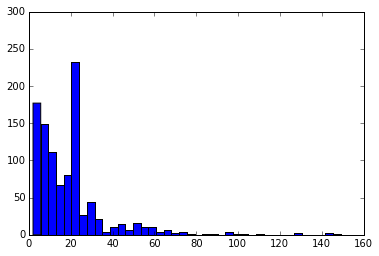

In [291]:
plt.hist(list(df_smaller.query('T_high_avg_nan > 0').service_duration), bins=40);
plt.ylim([0, 300]);

In [299]:
print len(df_smaller.query('T_high_avg_nan > 0 or T_low_avg_nan > 0').service_duration)
print len(df_smaller.query('T_max_nan > 0 or T_min_nan > 0'))

1013
98


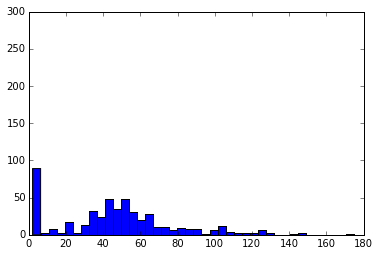

In [280]:
plt.hist(list(df_smaller.query('T_high_avg_nan == 0').service_duration), bins=40);
plt.ylim([0, 300]);

In [284]:
df_smaller['service_duration'] = df_smaller.end_date - df_smaller.start_date
dfx['service_duration'] = dfx.end_date - dfx.start_date

/Users/stephenmcmurtry/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  if __name__ == '__main__':


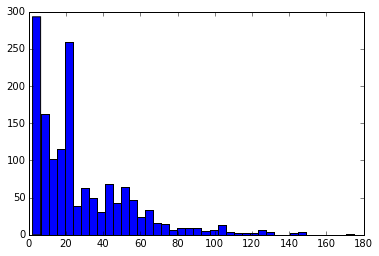

In [287]:
plt.hist([x for x in list(df_smaller.service_duration) if x == x], bins=40);
plt.ylim([0, 300]);

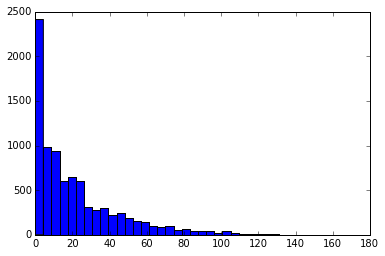

In [289]:
plt.hist([x for x in list(dfx.service_duration) if x == x], bins=40);
# plt.ylim([0, 300]);

In [28]:
dfx.columns

Index([u'name', u'province', u'climate_id', u'station_id', u'wmo_id', u'tc_id', u'latitude_decimal_degrees', u'longitude_decimal_degrees', u'latitude', u'longitude', u'elevation_m', u'start_date', u'end_date', u'T_high_avg_nan', u'T_min_nan', u'T_low_avg_nan', u'T_max_nan', u'period_T_low_nan', u'period_T_high_nan', u'T_min_year_nan', u'day_nan', u'T_max_year_nan', u'month_nan'], dtype='object')

In [56]:
df_smaller.to_csv('../data/station_shortlist.csv')

In [31]:
len(dfx)

12533

In [42]:
len(df_smaller)

1511

In [40]:
t = 1
dfx_nonan = dfx.query('T_high_avg_nan < @t and T_min_nan < @t and T_low_avg_nan < @t and T_max_nan < @t')
len(dfx_nonan)

1369

In [37]:
dfx_nonan.query('station_id == 51421')['T_low_avg_nan']

Series([], name: T_low_avg_nan, dtype: float64)

In [41]:
df_smaller['alm_stn_id'] = pd.Series(index=df_smaller.index)
df_smaller['alm_stn_dist'] = pd.Series(index=df_smaller.index)

In [43]:
for i1 in df_smaller.index[:]:
    print i1,
    stn_id_1 = df_smaller.station_id[i1]
    prov = df_smaller.province[i1]
    dfz = dfx_nonan.query('province == @prov')
    alm_stn_dist = 1000
    for i2 in dfz.index:
        stn_id_2 = dfz.station_id[i2]
        dist = get_dist_km(stn_id_1, stn_id_2, dfx)
        if dist < alm_stn_dist: 
            alm_stn_dist = dist
            alm_stn_id = stn_id_2
    df_smaller.ix[i1, 'alm_stn_id'] = alm_stn_id
    df_smaller.ix[i1, 'alm_stn_dist'] = alm_stn_dist

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

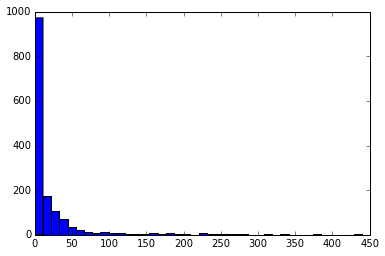

In [44]:
plt.hist(list(df_smaller.alm_stn_dist), bins=40);

(array([ 28.,  26.,   6.,   8.,   6.,   5.,   3.,   1.,   1.,   1.]),
 array([  50.20092054,   81.8796817 ,  113.55844286,  145.23720402,
         176.91596518,  208.59472634,  240.2734875 ,  271.95224866,
         303.63100982,  335.30977098,  366.98853214]),
 <a list of 10 Patch objects>)

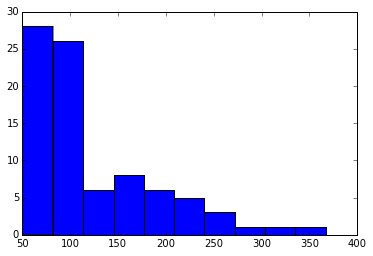

In [51]:
plt.hist(list(df_smaller.query('alm_stn_dist > 50').alm_stn_dist))

In [57]:
len(df_smaller.query('alm_stn_dist > 50'))

85

In [14]:
df_n = pd.DataFrame.from_csv('../data/normals/ALTA_ACAD-FIVE_ENG.csv')

In [15]:
len(df_n)

58835

In [16]:
df_n.columns

Index([u'STATION_NAME', u'PROVINCE', u'LATITUDE_DECIMAL_DEGREES', u'LONGITUDE_DECIMAL_DEGREES', u'ELEVATION', u'NORMAL_ID', u'NORMAL_ELEMENT_NAME', u'MONTH', u'VALUE', u'MONTHLY_NORMAL_CODE', u'ANNUAL_NORMAL_CODE', u'STATION_NORMAL_CODE', u'FIRST_OCCURRENCE_DATE', u'FIRST_YEAR', u'LAST_YEAR'], dtype='object')

In [17]:
len(set(df_n.NORMAL_ELEMENT_NAME))

128

In [18]:
len(set(df_n.NORMAL_ID))

128

In [19]:
normal_id_dict = {}
for i in set(df_n.NORMAL_ID):
    name = list(df_n.query('NORMAL_ID == @i').NORMAL_ELEMENT_NAME)[0]
    normal_id_dict[i] = name

In [20]:
normal_ids_of_interest = [52, 54, 56]
for i in normal_ids_of_interest:
    print i, normal_id_dict[i]

52 Total rainfall mm
54 Total snowfall cm
56 Total precipitation mm


In [71]:
df

,month,h_all_precip,h_rain,h_snow
0,1,19.8,50.0,NaN
1,2,20.8,32.2,NaN
2,3,16.0,26.8,NaN
3,4,0.0,30.2,NaN
4,5,0.0,22.8,NaN
5,6,0.0,17.0,NaN
6,7,0.0,24.4,NaN
7,8,0.0,35.1,NaN
8,9,0.0,24.0,NaN
9,10,6.6,36.0,NaN


In [85]:
df = pd.DataFrame()
for f in os.listdir('../data/normals/')[:]:
    if '_ENG.csv' not in f:
        continue
    if len(df) == 0:
        _df = pd.DataFrame.from_csv('../data/normals/' + f, index_col=None)
        df = _df.query('NORMAL_ID in @normal_ids_of_interest and MONTH != 13')
        continue
    df_temp = pd.DataFrame.from_csv('../data/normals/' + f, index_col=None)
    df_temp_2 = df_temp.query('NORMAL_ID in @normal_ids_of_interest and MONTH != 13')
    df = pd.concat([df_temp_2, df], ignore_index=True)
    print f

ALTA_FORE-ROCK_ENG.csv
ALTA_RONA-WORS_ENG.csv
BC_100-COWI_ENG.csv
BC_CRAN-JOE_ENG.csv
BC_KAML-NORT_ENG.csv
BC_OCHI-SILV_ENG.csv
BC_SIMI-WOOD_ENG.csv
BC_YOHO-YOHO_ENG.csv
MAN_ALEX-OCHR_ENG.csv
MAN_OSTE-ZHOD_ENG.csv
NB_ACAD-WOOD_ENG.csv
NFLD_ARNO-ROBE_ENG.csv
NFLD_ROCK-WOOD_ENG.csv
NS_ANNA-YARM_ENG.csv
NU_ALER-WHAL_ENG.csv
NWT_AKLA-YELL_ENG.csv
ONT_ALBI-GODF_ENG.csv
ONT_GORE-OTTA_ENG.csv
ONT_OWEN-WARR_ENG.csv
ONT_WATE-WOOL_ENG.csv
PEI_ALBE-WELL_ENG.csv
QUE_ALBA-KUUJ_ENG.csv
QUE_L'AL-QUEB_ENG.csv
QUE_RAPI-ST P_ENG.csv
QUE_ST R-WRIG_ENG.csv
SASK_ABBE-KIPL_ENG.csv
SASK_KURO-SWIF_ENG.csv
SASK_TISD-ZEHN_ENG.csv
YT_BEAV-WHIT_ENG.csv


In [86]:
len(df)

62772

In [87]:
df.to_csv('../data/normals/precip_only.csv', index=None)

In [88]:
len(set(df.CLIMATE_ID))

1759

In [89]:
df.columns

Index([u'CLIMATE_ID', u'STATION_NAME', u'PROVINCE', u'LATITUDE_DECIMAL_DEGREES', u'LONGITUDE_DECIMAL_DEGREES', u'ELEVATION', u'NORMAL_ID', u'NORMAL_ELEMENT_NAME', u'MONTH', u'VALUE', u'MONTHLY_NORMAL_CODE', u'ANNUAL_NORMAL_CODE', u'STATION_NORMAL_CODE', u'FIRST_OCCURRENCE_DATE', u'FIRST_YEAR', u'LAST_YEAR'], dtype='object')

In [91]:
def climate_id_dict_fn(val): return climate_id_dict[str(val)]

In [101]:
df['STATION_ID'] = df.CLIMATE_ID.apply(climate_id_dict_fn)

In [102]:
df2 = df.copy()

In [103]:
cols_to_keep = ['STATION_ID', 'NORMAL_ID', 'MONTH', 'VALUE'] 
#  'PROVINCE', , 'FIRST_YEAR', 'LAST_YEAR'

In [104]:
for c in df2:
    if c in cols_to_keep: continue
    del df2[c]

In [95]:
df2.to_csv('../data/normals/precip_only_short.csv', index=None)

In [50]:
len(set(df.NORMAL_ID))

3

In [111]:
prov_dict = {'ONTARIO':'ONT', 'NEWFOUNDLAND':'NFLD', 'BRITISH COLUMBIA':'BC',
             'SASKATCHEWAN':'SASK', 'PRINCE EDWARD ISLAND':'PEI', 'YUKON TERRITORY':'YT',
             'NOVA SCOTIA':'NS', 'QUEBEC':'QUE', 'ALBERTA':'ALTA', 'MANITOBA':'MAN',
             'NORTHWEST TERRITORIES':'NWT', 'NEW BRUNSWICK':'NB', 'NUNAVUT':'NU'}
def get_normal_stn_ids(prov):
    short_prov = prov_dict[prov]
    return list(set(df.query('PROVINCE == @short_prov').STATION_ID))



In [112]:
print set(df.PROVINCE)
print set(df_smaller.province)

set(['NWT', 'BC', 'NB', 'MAN', 'ALTA', 'NU', 'QUE', 'SASK', 'NFLD', 'NS', 'YT', 'ONT', 'PEI'])
set(['ONTARIO', 'NEWFOUNDLAND', 'BRITISH COLUMBIA', 'SASKATCHEWAN', 'PRINCE EDWARD ISLAND', 'YUKON TERRITORY', 'NOVA SCOTIA', 'QUEBEC', 'ALBERTA', 'MANITOBA', 'NORTHWEST TERRITORIES', 'NEW BRUNSWICK', 'NUNAVUT'])


In [116]:
df_smaller['norm_stn_id'] = pd.Series(index=df_smaller.index)
df_smaller['norm_stn_dist'] = pd.Series(index=df_smaller.index)

In [122]:
for i in df_smaller.index[:]:
    print i,
    prov = df_smaller.province[i]
    stn_id_1 = df_smaller.station_id[i]
    stn_ids = get_normal_stn_ids(prov)
    if stn_id_1 in stn_ids:
        norm_stn_dist = 0
        norm_stn_id = stn_id_1
    else:
        norm_stn_dist = 1000
        for stn_id_2 in stn_ids:
            dist = get_dist_km(stn_id_1, stn_id_2, dfx)
            if dist < norm_stn_dist:
                norm_stn_dist = dist
                norm_stn_id = stn_id_2
    df_smaller.ix[i, 'norm_stn_id'] = norm_stn_id
    df_smaller.ix[i, 'norm_stn_dist'] = norm_stn_dist

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [125]:
del df_smaller['Unnamed: 0']

In [45]:
df_smaller.to_csv('../data/station_shortlist.csv')

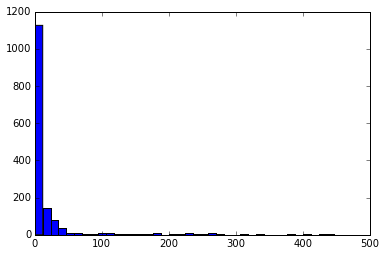

In [128]:
plt.hist(list(df_smaller.norm_stn_dist), bins=40);